# Clustering using K-means

For this weeks assignment, you will implement a *clustering* algorithm called K-means. Clustering algorithms are a type of unsupervised learning, meaning that the target variable of the data is not used. We will work with a classic dataset from machine learning; Fisher's Iris dataset. The dataset contains the measurements of *length* and *width* of the *sepals* and *petals* of 150 flowers. 

<img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Petal-sepal.jpg" width=250>

Using these 4 attributes (*length* and *width* of both *sepals* and *petals*), one could classify the flowers as as one of 3 species of Iris flower:

* Iris setosa
* Iris versicolor
* Iris virginica

We will not classify the data, but rather try to determine whether there are clusters identifyable in the data. Meaning that we will ignore the class labels.

This dataset is such a classic example that is even included in many machine learning libraries!

In [9]:
%matplotlib inline

import math
import matplotlib.pylab as plt
import numpy as np

from sklearn import datasets

data = datasets.load_iris().data
print(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

# Part 0: exploration
## Separate and plot the data 

The `iris` variable now contains an object with all sorts of information about the dataset. The 2 most important atributes are *target* and *data* containing respectively the labels and the data points for the 150 flowers. An attribute of this data object can be accessed with **.** as shown below.

Lets plot this data, so we can see what it looks like. We have prepared some code below that plots a so-called scatter matrix. This is a matrix of scatter plots that can be used to easily identify correlations and see the seperability of the dataset. The diagonals of this plot show how the data is distributed for every *single* feature, while the non-diagonals show scatter plots using *two* of the features as the $x$ and $y$ axis, with all the different possible configurations shown in the matrix.

The different colors here correspond to the different classes of Iris.

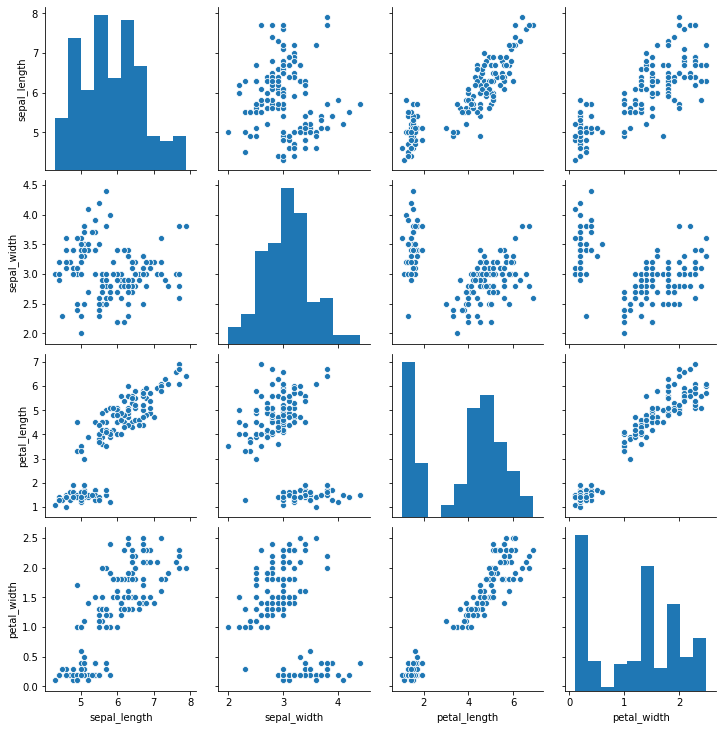

In [10]:
import seaborn as sns

df_iris = sns.load_dataset('iris')
sns.pairplot(df_iris)
plt.show()

Looking at these plots, it should be quite clear that there is one species that is more easily separated than the others. To make plotting and interpreting results easier, we will use only the petal_length and petal_width features to determine the clusters in our K-means algorithm, as these are the variables by which the dataset seems to be separated the easiest.

In [11]:
data = iris.data[:, 2:]

## One-hot encoding

Before we start with actually implementing the algorithm, there is another concept that we must introduce. This concept is the so-called _one-hot encoding_. A one-hot encoding is a representation of categorical variables as binary vectors. We will use this concept to keep track of which point was assigned to what cluster.

Let's say that after clustering we end up with three clusters of points; points that are assigned to cluster "0", cluster "1", and cluster "2". We could represent five points assigned to these clusters as:

```
[0, 2, 0, 0, 1]
```

The one-hot encoding of these categorical values can be represented as a binary vector of the length of the number of unique categories in our set. The binary vector is all zero values except the index of the integer, which is marked with a $1$. This results in a matrix containing a vector for each of our flowers:

```
[[1, 0, 0],
 [0, 0, 1],
 [1, 0, 0],
 [1, 0, 0],
 [0, 1, 0]]`
```

In each of these vectors there is only one $1$; hence the name _one-hot_ encoding. 

In practice, we could also choose to interpret these three clusters as the three different species of flowers that we know are present in this dataset: Setosa, Versicolor, and Virginica. Even though we do not really know which of the clusters represent what species, we could through some other method determine what cluster corresponds to what species. For example, we could determine that Setosa is $0$ or `[1, 0, 0]`, Versicolor is $1$ or `[0, 1, 0]`, and Virginica is $2$ or `[0, 0, 1]`:

```
["Setosa", "Virginica", "Setosa", "Setosa", "Versicolor"]
```

But why would you use a one-hot encoding? Well, many machine learning algorithms cannot work with categorical data directly. The categorical data _must_ be converted into numbers. This is required for both input and output variables that are categorical. Now, we could use an integer encoding directly. This may work for problems where there is a natural ordinal relationship between the categories, and in turn the integer values, such as labels for temperature ‘cold’, warm’, and ‘hot’. However, there may be problems when there is no ordinal relationship and allowing the representation to lean on any such relationship might be damaging to learning to solve the problem, as in a situation where you would have the labels ‘dog’ and ‘cat’.

As an exercise, implement the function `categorical_to_one_hot` below, that transforms a list of categorical values into a one-hot encoded matrix.

**Hint:** first, use `np.unique` to determine the size of the vector. Then, build the matrix of correct size using `np.zeros`, adjust the correct index in every row to a $1$, and return the result.

In [12]:
def categorical_to_one_hot(data):
    ### YOUR SOLUTION HERE
    height = len(data)
    length = len(np.unique(data))
    one_hot = np.zeros((height, length))
    
    for i in range(height):       
        one_hot[i, data[i]] = 1
                  
    return one_hot
    
### YOUR SOLUTION HERE
print(categorical_to_one_hot([0, 2, 0, 0, 1]))

[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


# Part 1: K-means 
## Implementing the algorithm
The goal of *K-means* is to find $k$ clusters, or groups, within a dataset. 
The formal pseudo-code for the algorithm to find $k$ clusters, is shown here:

* Initialize $m_i$, $i$ = $1$, ... , $k$, for example, to $k$ random $x^t$
* Until $m_i$ converges:
    * For all $x^t \in X$
        * $b_i^t \leftarrow \left\{\begin{array}{ll} 1 & if\ dist(x^t − m_i) \ =\ min_j\ dist( x^t − m_j )\\ 
            0 & otherwise \\ \end{array}\right.$
    * For all $m_i$, $i$ = $1$, ... , $k$
        * $m_i \leftarrow \sum_t b_i^t x^t / \sum_t b_i^t$

Where:

- $k$ is the number of clusters
- $m_i$ is the mean of cluster number $i$
- $x^t$ is point number $t$ from the dataset
- $b$ is the one-hot encoded matrix that maps points to a cluster
- $b_i^t$ (the values within $b$) is a boolean value that indicates whether point number $t$ belongs to cluster number $i$

As this pseudo-code is quite difficult to read, we will explain each of the different steps involved seperately:

1. Initialize the cluster means
2. While not converged: \
    2.1 Compute the new cluster assignment \
    2.2 Compute the new cluster means 
    
##### 1. Initialize the cluster means

Initializing the cluster means has to be done to create a starting point for our algorithm. The initialization of the cluster means will be done by taking a random point from the dataset. This ensures that each of the means starts at a sensible point.

##### 2. While not converged

The K-means algorithm is based on the fact that each of the iterations (sequences of aplying cluster assignment _and_ computing new means) done by the algorithm either improves upon the previous cluster assignment, or at least keeps it equally good. When the cluster assignments do not change after an iteration, the algorithm has _converged_ (not improved), and we can stop running it as no further improvement can be reached.

##### 2.1 Compute the new cluster assignment

This is where the pseudo-code gets a bit difficult to interpret, but you actually have already implemented a big part of it in part 0 of this module. For each of the points in the dataset a one-hot vector is built, where only the index of the cluster of which the mean is closest to the datapoint has value $1$, and all other clusters have value $0$. 

##### 2.2 Compute the new cluster means

This part of the pseudo-code uses the fact that we have built a one-hot encoded matrix to quickly and elegantly get the updated cluster means. For each of the cluster means, we need to take the average of the location of each of the assigned datapoints. This can be done in two steps. First by multiplying the column in our $b$ matrix that corresponds with a specific cluster by our datapoints, and summing the results, as the points that are not part of the cluster get multiplied by $0$, while the points that are a part of the cluster get multiplied by $1$. This results in a vector that we only have to divide by the number of points selected. So as a second step, we count the number of ones in the selected column of our $b$ matrix, and we divide the vector by the resulting number: 

$$ m_i \leftarrow \sum_t b_i^t x^t / \sum_t b_i^t $$

This is repeated for every cluster mean.

### Separating into functions
For your code, we will start making **functions** for each of the following components of the k-means algorithm:

* `init_clusters`: Randomly initialize means from the data
* `distance`: Compute the distance between 2 vectors
* `cluster_assignment`: Compute the matrix $b$ containing the assignments of points to clusters, based on the current means 
* `compute_means`: Compute the matrix $m$ containing the computed mean vectors, based on the current assignment of clusters 
* `plot_clusters`: Plot the means (as x's) and their assigned points (as dots), with a different color for each cluster (here you may assume the points will all be 2-dimensional, to allow them to be plotted)
* `is_converged`: Determine if the algorithm has converged based on the sets of current and new means
* `kmeans`: Combine all these functions in a general k-means function

_Keep in mind that to make plotting and interpreting results easier we use only two of the features in the dataset here. However, technically, it is possible to use a bigger amount features when utilizing K-means. Implement each of your functions in such a way that it would work for any number of features._

### `init_clusters`

This function should randomly initialize `k` means from the `data`. The initialization of the cluster means should be done by taking a random point from the dataset. This ensures that each of the means starts at a sensible point.

In [13]:
def init_clusters(data, k):
    ### YOUR SOLUTION HERE
    return np.random.permutation(data)[:k, :]

In [14]:
assert init_clusters(data, 1).shape == (1,2)
assert init_clusters(data, 4).shape == (4,2)
assert init_clusters([[1,2,3], [3, 2, 1]], 2).shape == (2, 3)

### `euc_dist` 

This function should compute the euclidean distance between 2 $N$-dimensional vectors `p` and `q`. The euclidean distance $d$ between vector $p$ and vector $q$ with $N$ dimensions is defined as:

$$ d(p,q) = \sqrt{\sum^N_{i=1}(p_i - q_i)^2} $$

In [15]:
def euc_dist(p, q):
    ### YOUR SOLUTION HERE
    return math.sqrt(np.sum(np.square(p - q)))

In [16]:
assert euc_dist(np.array([3, 3]), np.array([1, 3])) == 2
assert euc_dist(np.array([4, 2]), np.array([5, 1])) == math.sqrt(2)
assert euc_dist(np.array([1, 2, 3]), np.array([3, 2, 1])) == math.sqrt(8)

### `cluster_assignment`
Compute the matrix $b$ containing the assignments of `data` to clusters, based on the current cluster `means` and a given `dist_func`. This means that for every `point` in `data`, you should find the nearest cluster `mean`. The output is expected to be in _"one-hot"_ format, which means that for 4 datapoints, and 3 cluster means, the output should look like:

```
[[1, 0, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 0, 1]]
``` 
 
This means that point 0 was assigned to cluster 0, point 1 was assigned to cluster 1, point 2 was assigned to cluster 1, and point 3 was assigned to cluster 2. 

Essentially, we want to have a row for every 'point' in 'data', where every row contains only one "1" on the colum that indicates its nearest cluster mean.

In [17]:
def cluster_assignment(data, means, dist_func):
    ### YOUR SOLUTION HERE
    b = np.zeros((data.shape[0], means.shape[0]), dtype=float)
    for t, elem in enumerate(data):
        b[t][np.argmin([dist_func(elem, m) for m in means])] = 1
    return b

In [18]:
means = np.array([[0, 0], [999999, 999999]])

assert cluster_assignment(data, means, euc_dist).shape == (len(data), len(means)), "The output has the incorrect shape. It should have shape (len(data), len(means))."
assert np.sum(cluster_assignment(data, means, euc_dist), axis=0)[0] == 150, "Not everything was assigned to cluster 0."
assert np.allclose(np.ones((len(data), 1)), np.sum(cluster_assignment(data, means, euc_dist), axis=1)), "There are rows with more than or less than one \"1\""

means = np.array([[4.2, 1.3], [5.6, 2.2], [1.7, 0.2], [5.,  1.5], [4.6, 1.4]])

assert cluster_assignment(data, means, euc_dist).shape == (len(data), len(means)), "The output has the incorrect shape. It should have shape (len(data), len(means))."
assert np.sum(cluster_assignment(data, means, euc_dist)) == 150, "Not everything was assigned to a cluster."
assert np.allclose(np.ones((len(data), 1)), np.sum(cluster_assignment(data, means, euc_dist), axis=1)), "There are rows with more than or less than one \"1\""
assert np.allclose(cluster_assignment(data, means, euc_dist), np.array([[0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,1.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,1.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,1.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.]])), "Points were not properly assigned to the closest cluster mean."

### `compute_means` 
Compute the matrix $m$ containing the new computed mean vectors, based on the current assignment of clusters `b`. These mean vectors should be the locations of the cluster means (cluster centers), where $m_i$ is the mean that belongs to cluster number $i$. Use `b` to get all the `points` in `data` that are assigned to one cluster, and average the values to get the new cluster mean.

Note that it is possible that there is a cluster with no assigned points. When this is the case, it is impossible to calculate a new mean, so instead, use the value of a random point from `data` as this clusters' mean. This way, the next iteration in the k-means algorithm will assign at least one point to this cluster.

In [19]:
def compute_means(data, b):
    ### YOUR SOLUTION HERE
    means = []
    for i in range(b.shape[1]):
        s = np.sum(b[:, i])
        if s == 0:
            means.append(init_clusters(data, 1)[0])
        else:
            means.append(np.sum(data[b[:, i] == 1, :], axis=0) / s)
    return np.array(means)

In [20]:
assert compute_means(np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]), np.array([[1, 0],[1, 0], [0, 1]])).shape == (2, 3), "The output shape of your function is incorrect."
assert np.allclose(compute_means(np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]), np.array([[1, 0],[1, 0], [0, 1]])), np.array([[0.5, 2.5, 1.5], [1, 0, 1]])), "The computed means are incorrect."

b = np.array([[0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,1.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,1.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,1.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,1.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,0.,0.,0.,1.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [1.,0.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,0.,1.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.], [0.,1.,0.,0.,0.], [0.,1.,0.,0.,0.], [0.,0.,0.,1.,0.]])

assert np.allclose(compute_means(data, b), np.array([[3.92222222, 1.1962963], [5.79142857, 2.12857143], [1.462, 0.246], [5.00526316, 1.74736842], [4.57368421, 1.45263158]])), "The computed means are incorrect."

assert compute_means(np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]), np.array([[1, 0],[1, 0], [1, 0]]))[1] in  np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]), "The compute_means function does not properly handle clusters that have no assigned points."

### `plot_clusters`
Plot the `means` (as x's) and their assigned points (as dots), with a different color for each cluster (here you may assume the points will all be 2-dimensional, to allow them to be plotted). We have provided you with a set of colors that can be used in the plot. Make sure to give the points that belong to a cluster the same color as the cluster mean of that cluster.

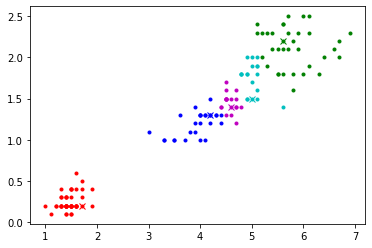

In [21]:
def plot_clusters(data, b, means):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    ### YOUR SOLUTION HERE
    for i in range(b.shape[1]):
        a = b[:, i] == 1
        plt.plot(data[a, 0], data[a, 1], '.'+colors[i])
    for i in range(means.shape[0]):
        plt.plot(means[i, 0], means[i, 1], 'x'+colors[i])
    ### END SOLUTION

plot_clusters(data, b, means)
plt.show()

### `is_converged`
Determine if the algorithm has converged based on the sets of `old` and `new` cluster means. Remember that the algorithm has _converged_ when the old and the new cluster means have not changed.


In [22]:
def is_converged(old, new):
    ### YOUR SOLUTION HERE
    return np.allclose(old, new)

In [23]:
assert is_converged(np.array([[1, 0]]), np.array([[1, 0]])), "Incorrect output for two equal mean matrices."
assert is_converged(np.array([[1, 0, 0], [0, 1, 0]]), np.array([[1, 0, 0], [0, 1, 0]])), "Incorrect output for two equal mean matrices."
assert is_converged(means, means), "Incorrect output for two equal mean matrices."
assert not is_converged(np.array([[1, 0]]), np.array([[0, 1]])), "Incorrect output for two unequal mean matrices."

### `kmeans`
Combine all these functions in a general k-means function. Recall the pseudocode we have shown at the start:

* Initialize $m_i$, $i$ = $1$, ... , $k$, for example, to $k$ random $x^t$
* Until $m_i$ converges
    * For all $x^t \in X$
        * $b_i^t \leftarrow \left\{\begin{array}{ll} 1 & if\ \Vert x^t − m_i \Vert \ =\ min_j\ \Vert x^t − m_j \Vert\\ 
            0 & otherwise \\ \end{array}\right.$
    * For all $m_i$, $i$ = $1$, ... , $k$
        * $m_i \leftarrow \sum_t b_i^t x^t / \sum_t b_i^t$

Or in text:

* Initialize the means
* While not converged
    * Get the new cluster assignment
    * Get the new cluster mean
    
At the end of the function, return the resulting cluster `means`.

In [24]:
def kmeans(data, k, dist_func):
    ### YOUR SOLUTION HERE
    means = init_clusters(data, k)
    old_means = means + 1
    
    while not is_converged(old_means, means):
        old_means = means
        b = cluster_assignment(data, means, dist_func)
        means = compute_means(data, b)  
                
    return means

In [25]:
assert kmeans(data, 3, euc_dist).shape == (3, data.shape[1]), "Your output has the incorrect shape."
assert kmeans(data, 12, euc_dist).shape == (12, data.shape[1]), "Your output has the incorrect shape."
assert np.all([mean in np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]) for mean in kmeans(np.array([[1, 3, 0], [0, 2, 3], [1, 0, 1]]), 3, euc_dist)]), "Your function assigns incorrect means"

## Showing the results

To show that your code works, run parts of the algorithm on the Iris dataset using `data`; use $k=3$ and plot the means with their assignments using `plot_clusters`. 

Start with the random means and then show at least 2 steps (just copy the code from your `kmeans` function), to show the means moving as the algorithm iterates. 

Finally, show the resulting plot where the means have converged and the algorithm has stopped.

Iteration:  0


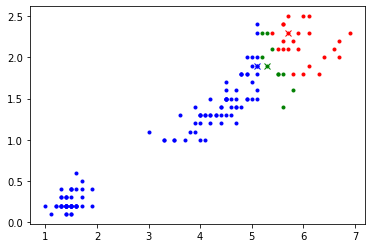

Iteration:  1


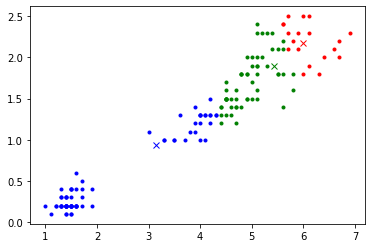

Iteration:  2


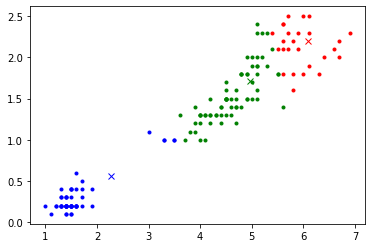

Converged Result


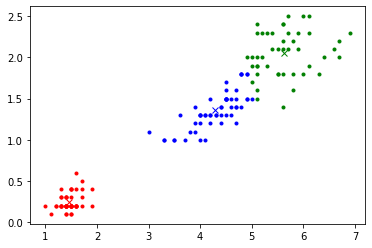

In [26]:
### YOUR SOLUTION HERE
means = init_clusters(data, 3)
for i in range(3):
    print("Iteration: ", i)
    b = cluster_assignment(data, means, euc_dist)
    plot_clusters(data, b, means)
    plt.show()
    means = compute_means(data, b)
    
print("Converged Result")
means = kmeans(data, 3, euc_dist)
b = cluster_assignment(data, means, euc_dist)
plot_clusters(data, b, means)
plt.show()

# Part 2: Distance metrics

In previous exercises (including this one) we have always used Euclidean distance, also known as the straight line distance, as our distance metric. However, there are more distance metrics that can be used that give different results and that might be preferable over the Euclidean distance when using specific types of data. The role of the distance function in K-means is to give the model a method of discerning a difference or ranking of the cluster means that are available.

An important note here is that there are two ways of looking at this problem. You could look at how similar two vectors are, or you could look at how distant or dissimilar two vectors are. For the former, generally, values get higher when vectors are more similar, while for the latter, the values get higher when vectors are less similar. 

The distance metric used in K-means greatly affects the result of the final clusters, as it changes the way the "closeness" of points to each of the cluster means is interpreted by the algorithm. In this part of the exercise we will implement a couple of these distance metrics and then see the effects they have on the clusters in the K-means algorithms. 

**The goal here is to program each of the distance functions without using `for`-loops.**

### Manhattan distance

The manhattan distance is ([also known as the "taxicab distance" or the "city block distance"](https://en.wikipedia.org/wiki/Taxicab_geometry)) defined as:

$$ d(p,q) = \sum^N_{i=1}abs(p_i - q_i) $$

It sums the absolute differences between the vectors $p$ and $q$ in every dimension. As an effect, the area in which something is less than $d$ away is square, not circular as it would be for the Euclidean distance.

Implement the function `man_dist` that calulates the manhattan distance between two vectors without using loops.

In [27]:
def man_dist(p, q):
    ### YOUR SOLUTION HERE
    return np.sum(np.abs(p - q))

### Cosine similarity

In practice, a measure that is often used for comparing different items is cosine similarity. To determine the cosine similarity you draw vectors from the origin to the datapoints, and take the angle between the vectors:

$$ cos(p, q) = \frac{\sum^N_{i=1}p_i * q_i}{\sqrt{\sum^N_{i=1}p_i^2} * \sqrt{\sum^N_{i=1}q_i^2}} $$

You've already seen this explained in SOWISO in a slightly other shape, which is rewritten here to fit our notation:

$$ cos(p, q) = \frac{p \cdot q}{\Vert p \Vert * \Vert q \Vert} $$

As a recap: Cosine similarity calculates the cosine of the angle between two vectors ($cos(angle)$), whereas the dot product is the product of the norm of two vectors and the cosine of the angle between them ($\Vert p \Vert * \Vert q \Vert cos(angle)$). This means that by dividing the result of the dot product by the product of the norm of the two vectors, we get the cosine similarity.

The values that come from application of the formula for Cosine similarity lie between $1$ and $-1$. Two vectors that have the same orientation have a cosine similarity of $1$, two vectors oriented at 90 degrees relative to each other have a similarity of $0$, and two opposing vectors have a similarity of $-1$. We need a formula to transform this cosine similarity to an angular distance:

$$ distance = \frac{acos(similarity)}{\pi} $$

This will convert the values from the range $1$ to $-1$ to the range $0$ to $1$.

First implement the function `sim_to_dist` that can convert the cosine similarity measure to a distance measure. Use the formula listed above using `math.acos`.

Then, implement the function `angle_dist` that calculates the cosine similarity of two vectors, then converts that similarity to a distance using `sim_to_dist`, and finally returns the distance.

In [28]:
def sim_to_dist(similarity):
    ### YOUR SOLUTION HERE
    similarity = max(min(1, similarity), -1)
    return math.acos(similarity) / math.pi

def angle_dist(p, q):
    ### YOUR SOLUTION HERE    
    return sim_to_dist(p.dot(q) / (np.linalg.norm(p) * np.linalg.norm(q)))

### Mean centering

The problem with cosine similarity is that it is highly sensitive to the position of the data relative to the origin. Lets say that our point cloud is translated by 100 in all dimensions. Now, the similarity of each point is suddenly much higher, as the angle between the points as observed from the origin has become smaller. What is often done to remedy this problem is _mean centering_. Mean centering or zero-centering is the act of subtracting a variable’s mean from all observations of that variable in the dataset such that the variable’s new mean is zero. Cosine similarity that is applied on a mean centered dataset is also called adjusted cosine similarity. 

Implement the function `center_data` that accepts a dataset and returns the same dataset, but mean centered. Then, display the newly centered data in a plot.

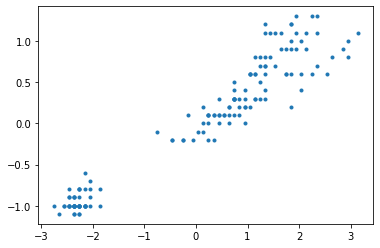

In [29]:
def center_data(data):
    ### YOUR SOLUTION HERE
    return data - np.mean(data, axis=0)

centered_data = center_data(data)

### YOUR SOLUTION HERE
plt.plot(*centered_data.T, '.')
plt.show()

### Mahalanobis distance

The Mahalanobis distance is a measure of the distance between two points $p$ and $q$ scaled according to a distribution $D$. Its principle is based on the idea of measuring how many standard deviations $p$ is from $q$ using the standard deviations from $D$. The intuitive explanation here is that we can decide whether a given distance from the center is noteworthy or not. If the distance between the test point $p$ and $q$ is less than one standard deviation, then it is highly probable that the test point belongs to the set. If the distance is further than that, it becomes more likely that the test point should not be classified as belonging to the cluster. 

As a result, the Mahalanobis distance is scale-invariant, which means that it does not matter if one variable is scaled differently from the other(s). For example, lets say we have a dataset that contains weight (in kilograms) and length (in meters) of several people, and we would want to find clusters herein. Both Manhattan distance and Euclidean distance would have troubles with this dataset, as the length of a person is considered equally as important as the weight of a person, while in reality a meter difference is much more important than a kilogram difference. By not using the Euclidean distance between two points, but instead considering the amount of standard deviations something is distant in each of the dimensions of our data, we eliminate the effects of scale.

The formula for the Mahalanobis distance (assuming that $p$ and $q$ are from the same distribution) is:

$$ d(p, q) = \sqrt{(p - q)^TS^{-1}(p - q)} $$

Where $S$ is the covariance matrix of the distribution. In our case, we do not know whether $p$ and $q$ are technically from the same distribution, but we can treat our entire dataset as if it is a single distribution. 

Implement the `maha_dist` function that calculates the Mahalobis distance. We have provided you with a function `maha_dist_generator` that makes sure that the function is within a scope that has the variable `S`, containing the covariance matrix of the data, available. The function `maha_dist_generator` returns the function `maha_dist` which you implement. You can use this function as if it is a normal function, but it will always have the covariance matrix `S` available.

**Hint:** to get $S^{-1}$ you can use Numpy's inverse function [`np.linalg.inv`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html#numpy.linalg.inv).

In [30]:
def maha_dist_generator(data):
    S = np.cov(data.T)
        
    def maha_dist(p, q):
        ### YOUR SOLUTION HERE
        return np.sqrt((p - q).T.dot(np.linalg.inv(S)).dot(p - q))
        
    return maha_dist

maha_dist = maha_dist_generator(centered_data)

### Displaying the effects

Now plot each of the distance functions you implemented. Use the code you wrote at [Showing the results](#Showing-the-results), but change it to show the name of the distance function as a title. Then, answer the questions below the code-cell.

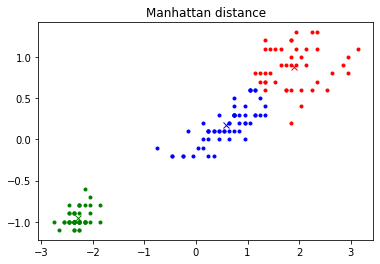

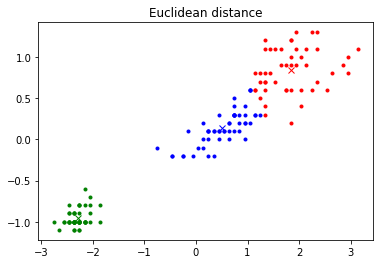

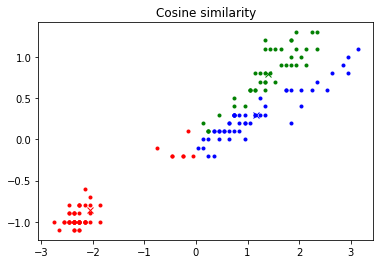

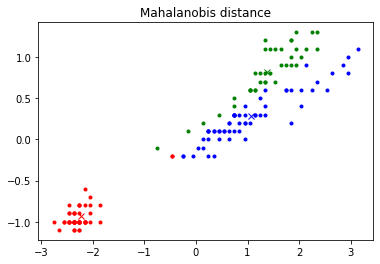

In [31]:
dist_func_dict = {"Manhattan distance": man_dist,
                 "Euclidean distance": euc_dist,
                 "Cosine similarity": angle_dist,
                 "Mahalanobis distance": maha_dist}

for dist_func_name, dist_func in dist_func_dict.items():
    ### YOUR CODE HERE
    means = kmeans(centered_data, 3, dist_func)
    b = cluster_assignment(centered_data, means, dist_func)
    plot_clusters(centered_data, b, means)
    
    plt.title(dist_func_name)
    plt.show()

**What do you think is a suitable value for $k$ for the iris dataset? Why?**

YOUR ANSWER HERE

**Which of the distance functions do you think is most suitable for the iris dataset? Explain.**

YOUR ANSWER HERE

**For each of the distance function, think of a dataset that it would be suitable for. Explain why that distance metric would be suitable for that dataset specifically. If you are unable to think of examples, feel free to use Google.**

YOUR ANSWER HERE

**BONUS: Of course it is also possible to define your own distance function. Think of a distance function that would work for a dataset comprised of two clusters that are concentric circles. No need for a formula.**

YOUR ANSWER HERE

# Part 3: elbow method

For this dataset we have the benefit that it is possible to see the correct number of clusters (either 2 or 3 clusters). However, even if the number clusters is not known or set before hand, there are ways to solve the clustering problem. One such possible approach is the *elbow method*.

Now extend your implementation to include the following:

* `cost`: Create a sensible cost function that is minimized when steps of the algorithm are done. This cost functions should be a good indication of the quality of the fit of the clusters. As such, make sure to make it represent a combination of the distances within each of the clusters. Use the data and the current values of $b$ and $m$.
* `average_cost`: Create a function to compute the converged cost of a specific value of $k$ repeatedly and averaging this.
* Compute the average cost for k values $1$ to $10$ on the Euclidean distance function and combine them in a plot. 
* **Briefly discuss if this plot corresponds with your expectations.**

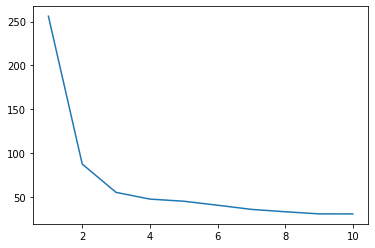

In [32]:
def cost(data, means, b, dist_func):
    ### YOUR SOLUTION HERE
    c = 0
    for i in range(means.shape[0]):
        c += sum([dist_func(means[i, :], elem) for elem in data[b[:, i] == 1, :]])
    return c

def average_cost(data, k, n, dist_func):
    ### YOUR SOLUTION HERE
    c = 0
    for i in range(n):
        m = kmeans(data, k, dist_func)
        b = cluster_assignment(data, m, dist_func)
        c += cost(data, m, b, dist_func)
    return c / n

### YOUR SOLUTION HERE
k_vals = range(1, 11)
c_vals = []
for k in k_vals:
    c_vals.append(average_cost(data, k, 10, euc_dist))

plt.plot(k_vals, c_vals)
plt.show()